# Assignment 6

## Task 1 (6 points)

You will predict bike sharing counts based on a number of features. 

Use the dataset `bike-sharing-daily.csv` from the lecture folder, which was downloaded from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

Use the first 600 samples in this data set to train a regression model of your choice - i.e. Linear Regression, Time Series Regression... - to predict the counts of shared bikes stored in the column `cnt`. The rest of the samples should be used as test set. A simple fixed split into a training and validation set (no nested, no kfold CV) will be enough for this task. You will not need the columns `casual` `registered` (their sum is stored in `cnt`).

After fitting the model, plot the true bike counts for the training and test data and plot the predicted counts on top (see the example expected output in `truth_vs_prediction.png` from the lecture folder). Also print some sort of evaluation score (for test accuracy, I expect you to be **better than 60%**).

In the end, identify a couple of outlier candidates with any method you like. For instance, you could single out the unusually high and/or low peaks in the graph. Visualize them however you want, just make it clear to the reader which points you refer to (which date in calender). Do you have an explanation for why the outliers occured on those dates? Write your hypothesis in the comments.

In [1]:
import pandas as pd
df = pd.read_csv('data/bike-sharing-daily.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [2]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

df.index = pd.to_datetime(df['dteday'])
df_train = df[:600]
df_test = df[600:]

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['temp','atemp','hum','windspeed']
categorical_features = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
target = 'cnt'
X_train = df_train[numeric_features + categorical_features]
y_train = df_train[target]


X_test = df_test[numeric_features + categorical_features]
y_test = df_test[target]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

reg.fit(X_train, y_train)

print("model score: %.3f" % reg.score(X_test, y_test))

model score: 0.653


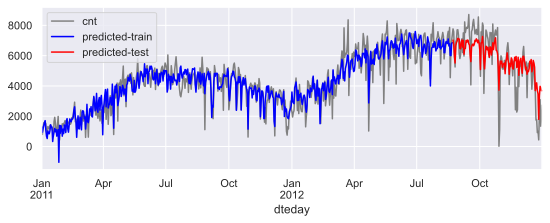

In [3]:
# Plot ground truth against prediction for training and test set

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9, 3]
import seaborn; seaborn.set()
ax = df[target].plot(color='grey')

y_predicted_train = pd.Series(index=y_train.index,
                              data=reg.predict(X_train),
                              name='predicted-train')
y_predicted_train.plot(ax=ax,color='blue')

y_predicted_test = pd.Series(index=y_test.index,
                             data=reg.predict(X_test),
                             name='predicted-test')
y_predicted_test.plot(ax=ax,color='red')

plt.legend()

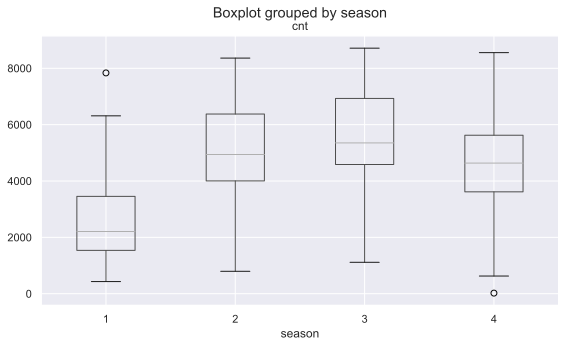

In [4]:
df.boxplot(by = "season", column = "cnt", figsize = (9, 5))
plt.show()

# Notice the two outliers: an upper one in season 1 (between 21.12 and 20.03) 
#                          and a lower one in season 4 (between 22.09 and 20.12)

In [5]:
# Lower outlier
min_rentals_s4 = min(df["cnt"][df["season"] == 4])
df["cnt"][df["season"] == 4][df["cnt"] == min_rentals_s4]

# Turns out a huge hurricane hit Washington that day
# https://en.wikipedia.org/wiki/Effects_of_Hurricane_Sandy_in_Maryland_and_Washington,_D.C.

dteday
2012-10-29    22
Name: cnt, dtype: int64

In [6]:
# Upper outlier
max_rentals_s1 = max(df["cnt"][df["season"] == 1])
df["cnt"][df["season"] == 1][df["cnt"] == max_rentals_s1]

# St. Patrick's Day

dteday
2012-03-17    7836
Name: cnt, dtype: int64

## Task 2 (4 points)

**Non-linear Classification and Nested Cross-Validation**

Load the *Iris* dataset from ``sklearn`` and train a non-linear classification model of your choice on it. 
Perform a **nested k-fold cross-validation**, with at least $k = 2$ folds and at least four hyperparameter combinations (for example, two different HPs for which you test two different values each). 

Report the final test accuracy score. I expect you achieve a **minimum of 80%**.

*Note*: you can play around and use two different $k$'s: one for the outermost loop that swipes the test set and another one for the middle loop that swipes the validation set. If you do that, test folds can have a different size than validation folds.

In [7]:
# You can use this import or not. Your choice :^)
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load Iris from sklearn
X_iris, y_iris = load_iris(return_X_y=True)
y_iris[48:52]

array([0, 0, 1, 1])

In [8]:
# Some nonlinear model
model = RandomForestClassifier(n_estimators = 10, random_state = 2022)
model.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state')

In [9]:
# Set up possible values of parameters to optimize over
p_grid = {"max_depth": [3, 4], "min_samples_leaf": [1, 10]}

# Choose cross-validation techniques for the inner and outer loops
inner_cv = KFold(n_splits=2, shuffle=True, random_state=2022)
outer_cv = KFold(n_splits=3, shuffle=True, random_state=2022)

# GridSearch cross-validation object hyperparameter optimization
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv, verbose=3)

# Nested CV with parameter optimization
nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv, verbose=3)
nested_score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  ................................................................
Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] max_depth=3, min_samples_leaf=1 .................................
[CV] ..... max_depth=3, min_samples_leaf=1, score=0.960, total=   0.0s
[CV] max_depth=3, min_samples_leaf=1 .................................
[CV] ..... max_depth=3, min_samples_leaf=1, score=0.940, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10 ................................
[CV] .... max_depth=3, min_samples_leaf=10, score=0.960, total=   0.0s
[CV] max_depth=3, min_samples_leaf=10 ................................
[CV] .... max_depth=3, min_samples_leaf=10, score=0.860, total=   0.0s
[CV] max_depth=4, min_samples_leaf=1 .................................
[CV] ..... max_depth=4, min_samples_leaf=1, score=0.960, total=   0.0s
[CV] max_depth=4, min_samples_leaf=1 .................................
[CV] ..... max_depth=4, min_samples_leaf=1, score=0.940, total=   0.0s
[CV] max_depth=4, 

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


0.9466666666666667